# STAT207 Mini-Project #2 - Fuel Data


Charlie Liu

**Delete this code block before submitting**

You should delete and add cells as you see fit.

Don't forget to put written text in **markdown** cells. To change a cell from a <u>code block</u> to a <u>markdown cell</u>:
* Click on the cell you'd like to modify.
* Go to 'Cell' at the top of the page.
* Go to 'Cell Type' in the drop down menu and click on either 'Code' or 'Markdown'.


In [108]:
# Data science libraries
# Feel free to add any we may need or remove the ones we don't.

import pandas as pd
import numpy as np
import math

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from scipy.stats import norm
from scipy.stats import t
from scipy.stats import bernoulli
from scipy.stats import binom

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score


## 1. Introduction

This project is dedicated to building a predictive model that will effectively predict the amount of CO2 coming from a vehicle's tailpipe in grams per mile in new datasets. Ideally, we would also like this model to yield reliable interprative insights about the nature of the relationship between the variables in the dataset. My motivation for choosing this research goal is because it creates a model that shows the factors that play into carbon emissions in various vehicles. Prospective customers that are more eco friendly may look for these traits, and car manufacturers may also look at this data to create a car that does not release as much carbon emissions.  

## 2. Dataset Discussion

I got this dataframe off of Kaggle (https://www.kaggle.com/datasets/sahirmaharajj/fuel-economy) on 3/26/2024. There are 38113 rows and many columns. Since I cannot use all of them, I trimmed the dataset down to only a few: year, drive, fuel type, highway mpg, city mpg, tailpipe CO2 emissions in grams per mile, greenhouse gas score, and if it is gasoline and electricity blended. 

In [56]:
# Read in the dataset
df = pd.read_csv('fuel.csv')

C:\Users\charl\AppData\Local\Temp\ipykernel_19808\1454566328.py:2: DtypeWarning: Columns (7,44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('fuel.csv')


In [57]:
# Select the variables that we want to use
df_use = df[['year', 'drive', 'fuel_type_1', 'city_mpg_ft1', 'highway_mpg_ft1', 'tailpipe_co2_in_grams_mile_ft1', 'ghg_score', 'gasoline_electricity_blended_cd']]

In [58]:
# Show the first few rows
df_use.head()

,year,drive,fuel_type_1,city_mpg_ft1,highway_mpg_ft1,tailpipe_co2_in_grams_mile_ft1,ghg_score,gasoline_electricity_blended_cd
0,1984,NaN,Regular Gasoline,17,24,444.350000,-1,False
1,1984,NaN,Regular Gasoline,17,24,444.350000,-1,False
2,1984,NaN,Regular Gasoline,18,25,423.190476,-1,False
3,1984,NaN,Regular Gasoline,18,25,423.190476,-1,False
4,1984,2-Wheel Drive,Regular Gasoline,18,17,522.764706,-1,False


In [59]:
# Length of the dataframe
len(df_use)

38113

## 3. Dataset Cleaning

To clean this dataset, I first looked all over the dataset to see if there were any implicit missing values for the categorical variables and there were none. Then I dropped the explicit missing values because that would be bad data for our model. Finally, I decided to limit the vehicles to only gas powered vehicles, that means dropping the electric vehicles and blended vehicles. I did this because gas powered engines tend to release more CO2 emissions. Finally I adjused the columns to get rid of the blended or not column because we already filtered it to only be false.

In [60]:
# # Find value types
df_drop.dtypes

year                                 int64
drive                               object
fuel_type_1                         object
city_mpg_ft1                         int64
highway_mpg_ft1                      int64
tailpipe_co2_in_grams_mile_ft1     float64
ghg_score                            int64
gasoline_electricity_blended_cd       bool
dtype: object

In [61]:
# drop NA values
df_drop = df_use.dropna()

In [62]:
# Look for implicit missing values in drive
df_drop['drive'].unique()

array(['2-Wheel Drive', '4-Wheel or All-Wheel Drive', 'Rear-Wheel Drive',
       'Front-Wheel Drive', '4-Wheel Drive', 'All-Wheel Drive',
       'Part-time 4-Wheel Drive'], dtype=object)

In [63]:
# Look for implicit missing values in fuel type
df_drop['fuel_type_1'].unique()

array(['Regular Gasoline', 'Diesel', 'Premium Gasoline', 'Natural Gas',
       'Electricity', 'Midgrade Gasoline'], dtype=object)

In [64]:
# drop the electric vehicles
df_clean = df_drop[(df_drop['fuel_type_1'] != "Electricity") & (df_drop['gasoline_electricity_blended_cd'] == False)]

In [65]:
# amount of dropped values
len(df_use) - len(df_clean)

1359

In [66]:
# drop boolean values not needed anymore
df_clean = df_clean.drop('gasoline_electricity_blended_cd', axis = 1)
df_clean.head()


,year,drive,fuel_type_1,city_mpg_ft1,highway_mpg_ft1,tailpipe_co2_in_grams_mile_ft1,ghg_score
4,1984,2-Wheel Drive,Regular Gasoline,18,17,522.764706,-1
5,1984,2-Wheel Drive,Regular Gasoline,18,17,522.764706,-1
6,1984,2-Wheel Drive,Regular Gasoline,13,13,683.615385,-1
7,1984,2-Wheel Drive,Regular Gasoline,13,13,683.615385,-1
8,1984,4-Wheel or All-Wheel Drive,Regular Gasoline,15,20,522.764706,-1


## 4. Preliminary Analysis

We start off the preliminary analysis by creating a numeric variable dataframe. This means that we will be able to make a pairplot of those variables and find the correlations between them. Off the bat, we are able to see that there may be some issues with multicollinearity between a few variables like: city mpg and highway mpg, city mpg and tailpipe CO2 emissions, and tailpipe CO2 emissions and highway mpg. Looking at the pairplots, we see that there is only a clear linear relationship between city mpg and highway mpg. 

In [67]:
# Numeric dataframe and correlation
df_num = df_clean[['year', 'city_mpg_ft1', 'highway_mpg_ft1', 'tailpipe_co2_in_grams_mile_ft1', 'ghg_score']]
df_num.corr()

,year,city_mpg_ft1,highway_mpg_ft1,tailpipe_co2_in_grams_mile_ft1,ghg_score
year,1.000000,0.162530,0.260757,-0.223814,0.591299
city_mpg_ft1,0.162530,1.000000,0.923989,-0.893694,0.351367
highway_mpg_ft1,0.260757,0.923989,1.000000,-0.928549,0.373926
tailpipe_co2_in_grams_mile_ft1,-0.223814,-0.893694,-0.928549,1.000000,-0.319097
ghg_score,0.591299,0.351367,0.373926,-0.319097,1.000000


c:\Users\charl\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\charl\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\charl\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\charl\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

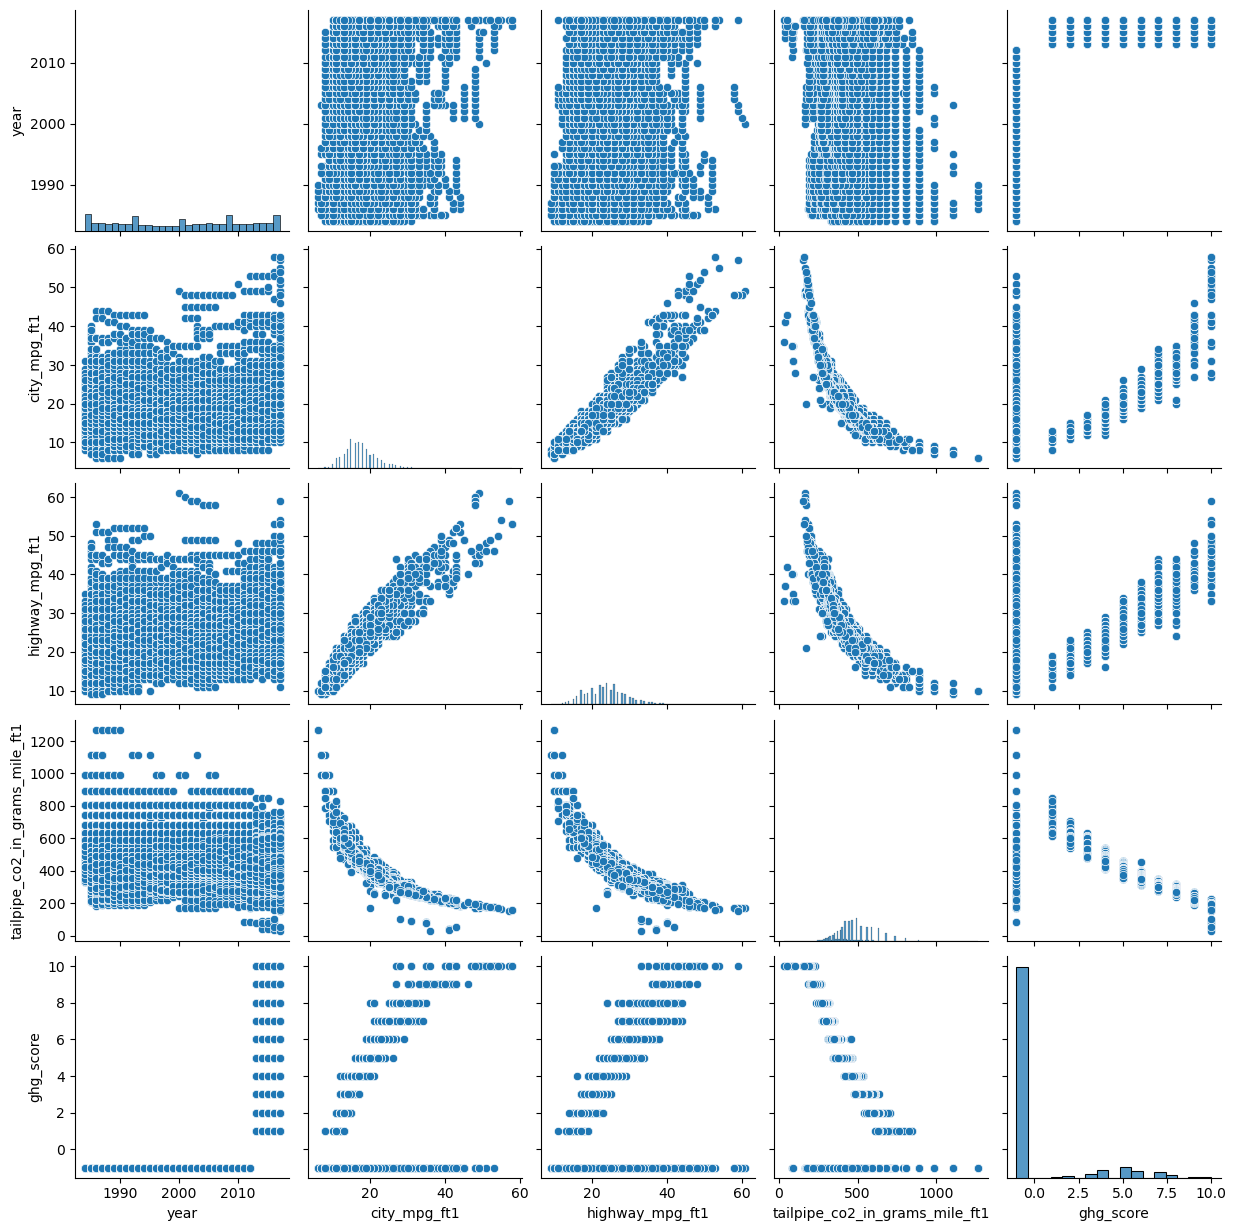

In [68]:
# make a pairplot out of numeric variables
sns.pairplot(data = df_num)

Next, in order to create a fitted values vs residuals graph, we need to create a full model in order to get the equation that we need. We end up getting this: 

^tailpipe_co2_in_grams_mile_ft1 = 1053.4525 - 26.1292(drive[T.4-Wheel Drive]) + drive[T.4-Wheel or All-Wheel Drive](-5.6144) + drive[T.All-Wheel Drive](-21.0223) + drive[T.Front-Wheel Drive](-3.4078) + drive[T.Part-time 4-Wheel Drive](-19.9421) + drive[T.Rear-Wheel Drive](-4.3728) + fuel_type_1[T.Midgrade Gasoline](-66.9326) + fuel_type_1[T.Natural Gas](-125.0977) + fuel_type_1[T.Premium Gasoline](-67.1346) + fuel_type_1[T.Regular Gasoline](-68.3261) + year(-0.0193) + city_mpg_ft1(-6.7395) + highway_mpg_ft1(-14.6212) + ghg_score(2.8779)

and we also had an R^2 value of .881. We then can get our fitted and residual values and plot them. The graph has a curve and has weak linearity which means that we have to transform it. 

In [69]:
# Create a model 
full_model = smf.ols('tailpipe_co2_in_grams_mile_ft1 ~ year + city_mpg_ft1 + highway_mpg_ft1 + ghg_score + drive + fuel_type_1', data = df_clean).fit()
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     tailpipe_co2_in_grams_mile_ft1   R-squared:                       0.881
Model:                                        OLS   Adj. R-squared:                  0.881
Method:                             Least Squares   F-statistic:                 1.950e+04
Date:                            Sun, 31 Mar 2024   Prob (F-statistic):               0.00
Time:                                    13:28:39   Log-Likelihood:            -1.8854e+05
No. Observations:                           36754   AIC:                         3.771e+05
Df Residuals:                               36739   BIC:                         3.772e+05
Df Model:                                      14                                         
Covariance Type:                        nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            1053.4525     58.088     18.136      0.000     939.599    1167.306
drive[T.4-Wheel Drive]                -26.1292      2.319    -11.266      0.000     -30.675     -21.583
drive[T.4-Wheel or All-Wheel Drive]    -5.6144      1.947     -2.883      0.004      -9.431      -1.798
drive[T.All-Wheel Drive]              -21.0223      2.171     -9.685      0.000     -25.277     -16.768
drive[T.Front-Wheel Drive]             -3.4078      1.971     -1.729      0.084      -7.271       0.455
drive[T.Part-time 4-Wheel Drive]      -19.9421      3.669     -5.435      0.000     -27.133     -12.751
drive[T.Rear-Wheel Drive]              -4.3728      1.924     -2.273      0.023      -8.143      -0.602
fuel_type_1[T.Midgrade Gasoline]      -66.9326      4.914    -13.621      0.000     -76.564     -57.301
fuel_type_1[T.Natural Gas]           -125.0977      5.486    -22.803      0.000    -135.850    -114.345
fuel_type_1[T.Premium Gasoline]       -67.1346      1.518    -44.217      0.000     -70.110     -64.159
fuel_type_1[T.Regular Gasoline]       -68.3261      1.461    -46.772      0.000     -71.189     -65.463
year                                   -0.0193      0.029     -0.658      0.510      -0.077       0.038
city_mpg_ft1                           -6.7395      0.128    -52.503      0.000      -6.991      -6.488
highway_mpg_ft1                       -14.6212      0.114   -128.036      0.000     -14.845     -14.397
ghg_score                               2.8779      0.121     23.798      0.000       2.641       3.115
==============================================================================
Omnibus:                    24164.694   Durbin-Watson:                   1.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           476270.987
Skew:                           2.879   Prob(JB):                         0.00
Kurtosis:                      19.669   Cond. No.                     5.45e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [70]:
# get fitted and residual values
fitted_vals = full_model.fittedvalues
resid_vals = full_model.resid

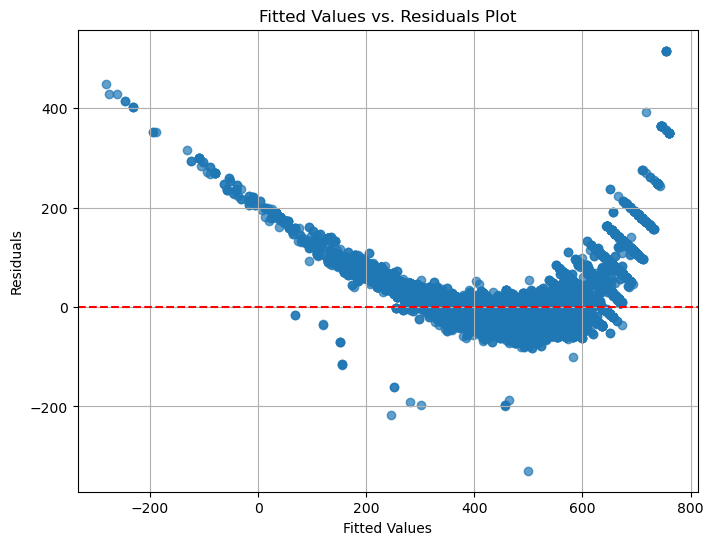

In [71]:
# Create fitted value VS residual graph
plt.figure(figsize=(8, 6))
plt.scatter(fitted_vals, resid_vals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Fitted Values vs. Residuals Plot')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

In order to transform it, I found the best way was to take the reciprocol or inverse it. We then get the equation: 

^tailpipe_co2_in_grams_mile_ft1 = -0.0002 - 1.771e-05(drive[T.4-Wheel Drive]) + drive[T.4-Wheel or All-Wheel Drive](1.025e-05) + drive[T.All-Wheel Drive](-2.009e-05) + drive[T.Front-Wheel Drive](8.213e-06) + drive[T.Part-time 4-Wheel Drive](-1.182e-05) + drive[T.Rear-Wheel Drive](1.579e-05) + fuel_type_1[T.Midgrade Gasoline](0.0003) + fuel_type_1[T.Natural Gas](.0009) + fuel_type_1[T.Premium Gasoline](.0004) + fuel_type_1[T.Regular Gasoline](.0003) + year(-9.912e-08) + city_mpg_ft1(9.183e-05) + highway_mpg_ft1(2.666e-05) + ghg_score(8.915e-06)

and we also had an R^2 value of .792 which is lower than when we did not transform it. However, it passes the linearity assumption much better than before transforming it. In both of these models, we can see that the fuel type variales have the most power in predicting tailpipe CO2 emissions. 

In [72]:
# transform graph by taking the reciprocol
inverse_y = 1 / (df_clean['tailpipe_co2_in_grams_mile_ft1'])
inverse_full_model = smf.ols('inverse_y ~ year + city_mpg_ft1 + highway_mpg_ft1 + ghg_score + drive + fuel_type_1', data = df_clean).fit()
inverse_fitted_vals = inverse_full_model.fittedvalues
inverse_resid_vals = inverse_full_model.resid
inverse_full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              inverse_y   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                 1.001e+04
Date:                Sun, 31 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:28:39   Log-Likelihood:             2.4622e+05
No. Observations:               36754   AIC:                        -4.924e+05
Df Residuals:                   36739   BIC:                        -4.923e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.0002      0.000     -0.398      0.691      -0.001       0.001
drive[T.4-Wheel Drive]              -1.771e-05   1.69e-05     -1.047      0.295   -5.09e-05    1.54e-05
drive[T.4-Wheel or All-Wheel Drive]  1.025e-05   1.42e-05      0.722      0.470   -1.76e-05    3.81e-05
drive[T.All-Wheel Drive]            -2.009e-05   1.58e-05     -1.269      0.204   -5.11e-05    1.09e-05
drive[T.Front-Wheel Drive]           8.213e-06   1.44e-05      0.572      0.568   -1.99e-05    3.64e-05
drive[T.Part-time 4-Wheel Drive]    -1.182e-05   2.67e-05     -0.442      0.659   -6.42e-05    4.06e-05
drive[T.Rear-Wheel Drive]            1.579e-05    1.4e-05      1.126      0.260   -1.17e-05    4.33e-05
fuel_type_1[T.Midgrade Gasoline]        0.0003   3.58e-05      9.560      0.000       0.000       0.000
fuel_type_1[T.Natural Gas]              0.0009      4e-05     21.938      0.000       0.001       0.001
fuel_type_1[T.Premium Gasoline]         0.0004   1.11e-05     33.415      0.000       0.000       0.000
fuel_type_1[T.Regular Gasoline]         0.0003   1.07e-05     32.078      0.000       0.000       0.000
year                                -9.912e-08   2.14e-07     -0.463      0.643   -5.18e-07     3.2e-07
city_mpg_ft1                         9.183e-05   9.36e-07     98.125      0.000       9e-05    9.37e-05
highway_mpg_ft1                      2.666e-05   8.33e-07     32.021      0.000     2.5e-05    2.83e-05
ghg_score                            8.915e-06   8.82e-07     10.112      0.000    7.19e-06    1.06e-05
==============================================================================
Omnibus:                   127406.930   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      41790740343.769
Skew:                          66.245   Prob(JB):                         0.00
Kurtosis:                    5225.201   Cond. No.                     5.45e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.45e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

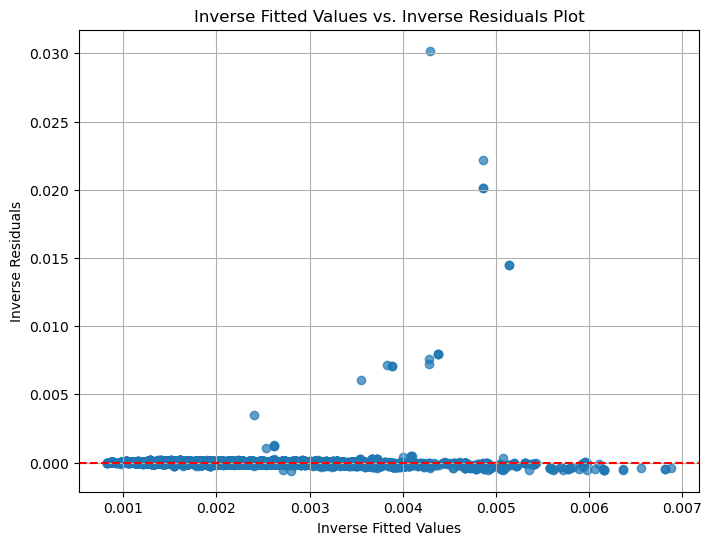

In [73]:
plt.figure(figsize=(8, 6))
plt.scatter(inverse_fitted_vals, inverse_resid_vals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Inverse Fitted Values vs. Inverse Residuals Plot')
plt.xlabel('Inverse Fitted Values')
plt.ylabel('Inverse Residuals')
plt.grid(True)
ax = plt.gca()
#ax.set_xlim([0, .008])
#ax.set_ylim([-.001, .001])
plt.show()

## 5. Predictive Models

To start the predictive models, we want to transform the categorical variables into a dummy variable so they have a numeric value. We can then perform a train test split with a 20/80 split with a random state of 207. We can then scale all of the test and train values into z scores. I decided to use all of the indicator variables in this full model. Even though fuel type was the best, the others still had power in predicting CO2 emissions. When transforming the test and train datasets into their inverses, the R^2 value and the non transformed version was much better than when it was. We end up getting a R^2 value of 0.8736662341114887.

In [74]:
# Create dummy variables
df_with_ind = pd.get_dummies(df_clean, drop_first = True, dtype = int)
df_with_ind.head()

,year,city_mpg_ft1,highway_mpg_ft1,tailpipe_co2_in_grams_mile_ft1,ghg_score,drive_4-Wheel Drive,drive_4-Wheel or All-Wheel Drive,drive_All-Wheel Drive,drive_Front-Wheel Drive,drive_Part-time 4-Wheel Drive,drive_Rear-Wheel Drive,fuel_type_1_Midgrade Gasoline,fuel_type_1_Natural Gas,fuel_type_1_Premium Gasoline,fuel_type_1_Regular Gasoline
4,1984,18,17,522.764706,-1,0,0,0,0,0,0,0,0,0,1
5,1984,18,17,522.764706,-1,0,0,0,0,0,0,0,0,0,1
6,1984,13,13,683.615385,-1,0,0,0,0,0,0,0,0,0,1
7,1984,13,13,683.615385,-1,0,0,0,0,0,0,0,0,0,1
8,1984,15,20,522.764706,-1,0,1,0,0,0,0,0,0,0,1


In [91]:
df_train1, df_test1 = train_test_split(df_clean,test_size=0.20,random_state=207)

In [75]:
# Perform a train split test with a 20/80 split with a random split of 207 with indicator vars
df_train, df_test = train_test_split(df_with_ind,test_size=0.20,random_state=207)

In [76]:
# Z-Score Scale using training mean and std
mean = df_train.mean()
std = df_train.std()

df_train_scaled = pd.DataFrame((df_train - mean) / std, columns=df_train.columns)

df_test_scaled = pd.DataFrame((df_test - mean) / std, columns=df_test.columns)

In [77]:
# Transform them
X_train=df_train_scaled.drop(['tailpipe_co2_in_grams_mile_ft1'], axis=1)
inverse_X_train = 1 / X_train
inverse_X_train.head()

,year,city_mpg_ft1,highway_mpg_ft1,ghg_score,drive_4-Wheel Drive,drive_4-Wheel or All-Wheel Drive,drive_All-Wheel Drive,drive_Front-Wheel Drive,drive_Part-time 4-Wheel Drive,drive_Rear-Wheel Drive,fuel_type_1_Midgrade Gasoline,fuel_type_1_Natural Gas,fuel_type_1_Premium Gasoline,fuel_type_1_Regular Gasoline
3543,-0.651600,12.534704,-3.223088,-2.377240,-5.696632,0.469687,-4.107887,-1.329926,-14.406213,-1.349858,-22.690518,-24.992339,-1.604656,1.503635
29316,1.089385,-1.789906,-7.332913,-2.377240,-5.696632,-2.129149,-4.107887,-1.329926,-14.406213,0.740844,-22.690518,-24.992339,0.623208,-0.665078
12753,-1.333614,0.874210,2.595390,-2.377240,-5.696632,-2.129149,-4.107887,0.751947,-14.406213,-1.349858,-22.690518,-24.992339,-1.604656,1.503635
36610,0.663755,0.637132,1.102574,0.396584,-5.696632,-2.129149,0.243442,-1.329926,-14.406213,-1.349858,-22.690518,-24.992339,0.623208,-0.665078
36823,0.663755,0.379702,0.470766,0.297428,-5.696632,-2.129149,-4.107887,0.751947,-14.406213,-1.349858,-22.690518,-24.992339,-1.604656,1.503635


In [78]:
y_train=df_train_scaled['tailpipe_co2_in_grams_mile_ft1']
inverse_y_train = 1 / y_train
inverse_y_train.head()

3543    -3.769207
29316    6.558847
12753   -1.121116
36610   -0.852026
36823   -0.577319
Name: tailpipe_co2_in_grams_mile_ft1, dtype: float64

In [79]:
X_test=df_test_scaled.drop(['tailpipe_co2_in_grams_mile_ft1'], axis=1)
inverse_X_test = 1 / X_test
inverse_X_test.head()

,year,city_mpg_ft1,highway_mpg_ft1,ghg_score,drive_4-Wheel Drive,drive_4-Wheel or All-Wheel Drive,drive_All-Wheel Drive,drive_Front-Wheel Drive,drive_Part-time 4-Wheel Drive,drive_Rear-Wheel Drive,fuel_type_1_Midgrade Gasoline,fuel_type_1_Natural Gas,fuel_type_1_Premium Gasoline,fuel_type_1_Regular Gasoline
14495,-1.806256,-1.789906,-3.223088,-2.37724,-5.696632,0.469687,-4.107887,-1.329926,-14.406213,-1.349858,-22.690518,-24.992339,0.623208,-0.665078
23200,2.339608,-0.835313,-0.847665,-2.37724,-5.696632,-2.129149,-4.107887,-1.329926,-14.406213,0.740844,-22.690518,-24.992339,-1.604656,1.503635
19395,28.570871,-7.516322,4.730177,-2.37724,-5.696632,-2.129149,-4.107887,-1.329926,-14.406213,0.740844,-22.690518,-24.992339,0.623208,-0.665078
17986,-15.846690,-0.616219,-0.847665,-2.37724,-5.696632,-2.129149,-4.107887,-1.329926,-14.406213,0.740844,-22.690518,-24.992339,0.623208,-0.665078
22133,3.036590,1.074036,0.925190,-2.37724,-5.696632,-2.129149,-4.107887,0.751947,-14.406213,-1.349858,-22.690518,-24.992339,-1.604656,1.503635


In [80]:
y_test=df_test_scaled['tailpipe_co2_in_grams_mile_ft1']
inverse_y_test = 1 / (y_test)
inverse_y_test.head()

14495    6.558847
23200    0.742884
19395   -3.769207
17986    0.446163
22133   -0.982994
Name: tailpipe_co2_in_grams_mile_ft1, dtype: float64

In [81]:
# Set up linear regression
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(inverse_X_train, inverse_y_train)

LinearRegression()

In [82]:
# Get R^2 score
lin_reg_mod.score(inverse_X_test, inverse_y_test)


0.021690831459751814

In [83]:
# Set up non transformed linear regression
lin_reg_mod1 = LinearRegression()
lin_reg_mod1.fit(X_train, y_train)

LinearRegression()

In [84]:
# Get R^2 score
lin_reg_mod1.score(X_test, y_test)

0.8736662341114887

Now we start the feature selection process. I did a LASSO and Ridge regression and we will compare which one has the better R^2 value so we know which is the best to use. The LASSO regression ended up having the highest R^2 value at 0 at 0.873666. The Ridge regression had its highest R^2 value at 11.2 with a value of 0.873667. Even though these are pretty much the same, the ridge regression model still had the highest R^2 value which means it is the better model since it can explain more of the model. 

In [98]:
data=[]
for i in np.arange(0,.5,0.005):
    lasso = Lasso(alpha = i, max_iter = 1000)
    lasso.fit(X_train, y_train)
    data.append([i, lasso.score(X_test, y_test)])
df_dataframe = pd.DataFrame(data, columns=["lambda", "test R^2"])
df_dataframe

c:\Users\charl\miniconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\charl\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\charl\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e+03, tolerance: 2.940e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordi

,lambda,test R^2
0,0.000,0.873666
1,0.005,0.872655
2,0.010,0.869251
3,0.015,0.865959
4,0.020,0.864560
...,...,...
95,0.475,0.632932
96,0.480,0.628028
97,0.485,0.623237
98,0.490,0.618396


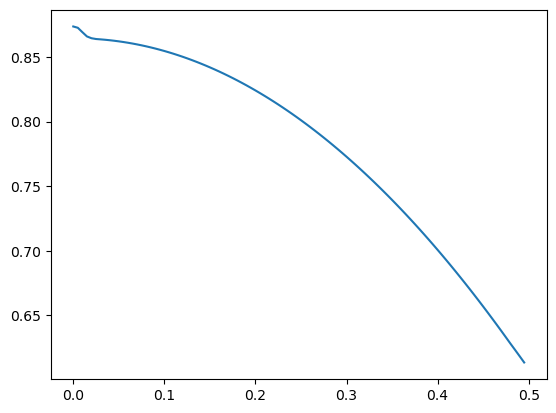

In [99]:
plt.plot(df_dataframe["lambda"].values, df_dataframe['test R^2'].values)

In [100]:
df_dataframe.nlargest(1, "test R^2")

,lambda,test R^2
0,0.0,0.873666


In [119]:
LASSO_model = Lasso(alpha = 0.0, max_iter = 1000)
LASSO_model.fit(X_train, y_train)

c:\Users\charl\miniconda3\Lib\site-packages\sklearn\base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\charl\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\charl\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e+03, tolerance: 2.940e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordi

Lasso(alpha=0.0)

In [120]:
slopes = pd.DataFrame({"LASSO_model": LASSO_model.coef_.T}, index = X_train.columns)
slopes

,LASSO_model
year,-0.001869
city_mpg_ft1,-0.273521
highway_mpg_ft1,-0.707543
ghg_score,0.058339
drive_4-Wheel Drive,-0.039258
drive_4-Wheel or All-Wheel Drive,-0.018874
drive_All-Wheel Drive,-0.040780
drive_Front-Wheel Drive,-0.014683
drive_Part-time 4-Wheel Drive,-0.012344
drive_Rear-Wheel Drive,-0.019507


In [127]:
temp_list1 = []
for i in np.arange(0, 20, .2):
    ridge = Ridge(alpha = i, max_iter = 1000)
    ridge.fit(X_train, y_train)
    temp_list1.append([i, ridge.score(X_test, y_test)])
temp_list1

[[0.0, 0.8736662341114887],
 [0.2, 0.8736662600728355],
 [0.4, 0.8736662855545706],
 [0.6000000000000001, 0.8736663105570238],
 [0.8, 0.8736663350805253],
 [1.0, 0.8736663591254046],
 [1.2000000000000002, 0.8736663826919913],
 [1.4000000000000001, 0.8736664057806145],
 [1.6, 0.8736664283916034],
 [1.8, 0.8736664505252862],
 [2.0, 0.873666472181992],
 [2.2, 0.8736664933620487],
 [2.4000000000000004, 0.8736665140657841],
 [2.6, 0.8736665342935264],
 [2.8000000000000003, 0.8736665540456027],
 [3.0, 0.8736665733223403],
 [3.2, 0.8736665921240665],
 [3.4000000000000004, 0.8736666104511078],
 [3.6, 0.8736666283037908],
 [3.8000000000000003, 0.8736666456824418],
 [4.0, 0.8736666625873868],
 [4.2, 0.8736666790189515],
 [4.4, 0.8736666949774615],
 [4.6000000000000005, 0.8736667104632424],
 [4.800000000000001, 0.8736667254766188],
 [5.0, 0.873666740017916],
 [5.2, 0.8736667540874582],
 [5.4, 0.8736667676855698],
 [5.6000000000000005, 0.8736667808125752],
 [5.800000000000001, 0.873666793468798],


In [128]:
df_dataframe_1 = pd.DataFrame(temp_list1, columns=["lambda", "test R^2"])
df_dataframe_1

,lambda,test R^2
0,0.0,0.873666
1,0.2,0.873666
2,0.4,0.873666
3,0.6,0.873666
4,0.8,0.873666
...,...,...
95,19.0,0.873667
96,19.2,0.873667
97,19.4,0.873667
98,19.6,0.873667


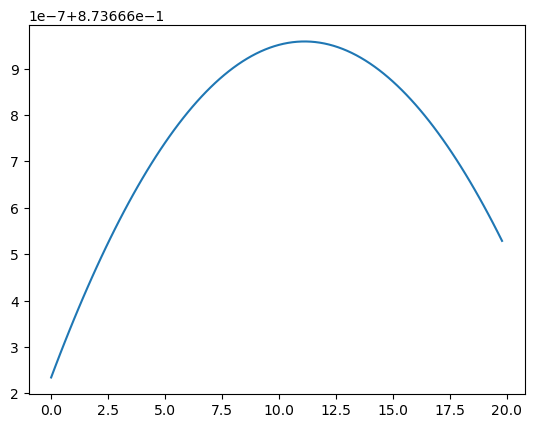

In [129]:
plt.plot(df_dataframe_1['lambda'].values, df_dataframe_1['test R^2'].values)

In [130]:
df_dataframe_1.nlargest(1, "test R^2")

,lambda,test R^2
56,11.2,0.873667


In [132]:
ridge_model = Ridge(alpha = 11.2, max_iter = 1000)
ridge_model.fit(X_train, y_train)

Ridge(alpha=11.2, max_iter=1000)

In [135]:
ridge_model.intercept_

-5.032254835070775e-16

In [134]:
df_slopes = pd.DataFrame({"Ridge_model": ridge_model.coef_.T,"LASSO_model": LASSO_model.coef_.T,"Non_regularized_model": lin_reg_mod.coef_.T}, index = X_train.columns)
df_slopes

,Ridge_model,LASSO_model,Non_regularized_model
year,-0.002198,-0.001869,0.006551
city_mpg_ft1,-0.274612,-0.273521,0.021724
highway_mpg_ft1,-0.705773,-0.707543,-0.178544
ghg_score,0.058255,0.058339,0.740060
drive_4-Wheel Drive,-0.039071,-0.039258,-0.353997
drive_4-Wheel or All-Wheel Drive,-0.018529,-0.018874,0.103999
drive_All-Wheel Drive,-0.040657,-0.040780,-0.043582
drive_Front-Wheel Drive,-0.014873,-0.014683,-0.765379
drive_Part-time 4-Wheel Drive,-0.012244,-0.012344,-0.133619
drive_Rear-Wheel Drive,-0.019235,-0.019507,0.181812


## 6. Best Model Discussion

The best equation that we got was for the Ride regression model. It is: 

^tailpipe_co2_in_grams_mile_ft1 = year(-0.002198) + city_mpg_ft1(-0.274612) + highway_mpg_ft1(-0.705773) + ghg_score(0.058255) + drive_4-Wheel Drive(-0.039071) + drive_4-Wheel or All-Wheel Drive(-0.018529) + drive_All-Wheel Drive(-0.040657) + drive_Front-Wheel Drive(-0.014873) + drive_Part-time 4-Wheel Drive(-0.012244) + drive_Rear-Wheel Drive(-0.019235) + fuel_type_1_Midgrade Gasoline(-0.024704) + fuel_type_1_Natural Gas(-0.042585) + fuel_type_1_Premium Gasoline(-0.256152) + fuel_type_1_Regular Gasoline(-0.267050) - 5.032254835070775e-16

The overall fit for this model is very good since we have a high R^2 value which means that 0.873667 of the model is explained by this equation. There were no transformations necesssary in this case so there were no signs of overfitting in this model. Looking at the correlation table below, there doesn't seem to be any signs of overfitting besides city mpg and highway mpg, which does make sense why there is a high correlation. Based on the magnitude of the slopes it seems like highway mpg has the most power in predicting CO2 emissions, the next few that are the highest were premium gasoline, regular gasoline, and city mpg. 

In [106]:
X_train.corr()

,year,city_mpg_ft1,highway_mpg_ft1,ghg_score,drive_4-Wheel Drive,drive_4-Wheel or All-Wheel Drive,drive_All-Wheel Drive,drive_Front-Wheel Drive,drive_Part-time 4-Wheel Drive,drive_Rear-Wheel Drive,fuel_type_1_Midgrade Gasoline,fuel_type_1_Natural Gas,fuel_type_1_Premium Gasoline,fuel_type_1_Regular Gasoline
year,1.000000,0.166971,0.265151,0.591619,0.215789,-0.135237,0.314078,-0.025494,0.090865,-0.062921,0.058662,0.008416,0.308297,-0.267691
city_mpg_ft1,0.166971,1.000000,0.923262,0.352185,-0.023058,-0.257499,0.039043,0.553795,-0.041821,-0.342141,-0.025281,-0.016376,-0.099620,0.068423
highway_mpg_ft1,0.265151,0.923262,1.000000,0.374139,-0.033525,-0.340981,0.071152,0.606875,-0.054583,-0.328301,-0.010447,-0.013303,0.009508,-0.030160
ghg_score,0.591619,0.352185,0.374139,1.000000,0.159262,-0.197577,0.305576,0.045811,0.052536,-0.086656,0.042883,-0.011464,0.142716,-0.134566
drive_4-Wheel Drive,0.215789,-0.023058,-0.033525,0.159262,1.000000,-0.082450,-0.042734,-0.131999,-0.012186,-0.130049,0.055827,-0.007024,0.051217,-0.056927
drive_4-Wheel or All-Wheel Drive,-0.135237,-0.257499,-0.340981,-0.197577,-0.082450,1.000000,-0.114338,-0.353168,-0.032603,-0.347953,-0.020700,-0.014368,-0.058777,0.051109
drive_All-Wheel Drive,0.314078,0.039043,0.071152,0.305576,-0.042734,-0.114338,1.000000,-0.183050,-0.016898,-0.180347,0.022915,-0.009741,0.149955,-0.142023
drive_Front-Wheel Drive,-0.025494,0.553795,0.606875,0.045811,-0.131999,-0.353168,-0.183050,1.000000,-0.052196,-0.557056,-0.031530,0.001815,-0.173160,0.188840
drive_Part-time 4-Wheel Drive,0.090865,-0.041821,-0.054583,0.052536,-0.012186,-0.032603,-0.016898,-0.052196,1.000000,-0.051425,-0.003059,-0.002778,-0.032292,0.035489
drive_Rear-Wheel Drive,-0.062921,-0.342141,-0.328301,-0.086656,-0.130049,-0.347953,-0.180347,-0.557056,-0.051425,1.000000,0.019078,0.018414,0.152460,-0.156794


## 7. Conclusion

I would recommend this model be used by people looking for a eco friendly car and designers that may be trying to create an eco friendly car. This model shows that cars with higher mpg in general, and that use premium and regular gasoline tend to be more eco friendly. Cars with high greenhouse gas ratings tend to be less eco-friendly. I am not sure that the chosen model is the best since I did not do an elastic net model. I think that is one of the shortcomings and if I did do one I may be able to find a higher R^2 value.